# Problem
- Given a number: **K**
- 2 players play a dice game
    + Player 1 throws the dice and get the number
    + Player 2 throws the dice and get the number
- Denote
    + $s_1$: Sum of player 1 numbers
    + $s_2$: Sum of player 2 numbers
- Game Rule
    + If $|s_1 - s_2| \geq K$: Game end
    + If $|s_1 - s_2| < K$: go to next turn
- Find the Expected value of turns

#### Examples

```
K = 1 -> E = 1.200000000
K = 2 -> E = 1.775342466
K = 3 -> E = 2.736743313
```

# Analyze
- Each turn: Roll 2 die -> Total 10 outcomes

In [1]:
from numpy.random import randint
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

{-5: 1, -4: 2, -3: 3, -2: 4, -1: 5, 0: 6, 1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
Sample size = 36


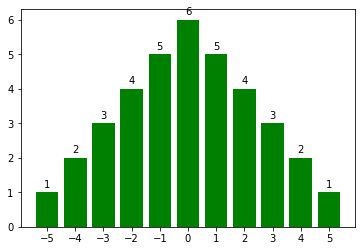

In [3]:
from itertools import product

# Possibility in range [2,12]
results = dict.fromkeys(range(-5,6), 0)

# Generate all possible outcomes
outcomes = list(product(range(1,7), range(1,7)))
sample_size = len(outcomes)
for (d1,d2) in outcomes:
    results[d1-d2] += 1

# Print
print(results)
print("Sample size = {}".format(sample_size))

# Plot
fig, ax = plt.subplots()
data_plot = ax.bar(results.keys(), results.values(), color='g')

autolabel(data_plot)
plt.xticks(np.arange(-5,6))

plt.show()

## Probability Graph
- If $|s_1 - s_2| > K$ game end -> Total $2*K-1$ Expected values. Let
    - $E_0$: Expected value when $s_1 - s_2 = 0$
    - $E_{-1}$:  Expected value when $s_1 - s_2 = -1$, Player 1 losing 1
    - $E_{+1}$:  Expected value when $s_1 - s_2 = 1$, Player 2 losing 1
    - $\dots$
    - $E_{-(K-1)}$:  Expected value when $s_1 - s_2 = -(K-1)$, Player 1 losing K
    - $E_{(K-1)}$:  Expected value when $s_1 - s_2 = (K-1)$, Player 2 losing K
- Build Probability Graphs from $E_i$ -> $E_j$: (distance = $[-5, 5]$)

#### Example $K = 1$

<img src="./img/1.png" width="600"/>

- $E_0 = 1.2$

#### Example $K = 2$

| <img src="./img/2.png" width="800"/> | <img src="./img/4.png" width="600"/> | <img src="./img/3.png" width="600"/> |
|--------------------------------------|--------------------------------------|--------------------------------------|

- Solve the system

$$\begin{cases}
    \frac{30}{36}E_0 -\frac{5}{36}E_{-1} - \frac{5}{36}E_{+1} &= 1 \\
    -\frac{5}{36}E_0 +\frac{30}{36}E_{-1} - \frac{4}{36}E_{+1} &= 1 \\
    -\frac{5}{36}E_0 -\frac{4}{36}E_{-1} + \frac{30}{36}E_{+1} &= 1
\end{cases}$$

- $->\ E_0 = 1.775342466$

# Solution

```C++
int translate(int i) {
    // -: odd, +: even
    // Eg: -1 -> 1, 1 -> 2
    if(i < 0) return 2.0*abs(i) - 1;
    return 2*i;
}


double solve() {
    // Probability lookup
    unordered_map<int, double> Prob({
        {-5, 1.0 / 36},
        {-4, 2.0 / 36},
        {-3, 3.0 / 36},
        {-2, 4.0 / 36},
        {-1, 5.0 / 36},
        { 0, 6.0 / 36},
        { 1, 5.0 / 36},
        { 2, 4.0 / 36},
        { 3, 3.0 / 36},
        { 4, 2.0 / 36},
        { 5, 1.0 / 36},
    });

    // Build A
    vector<vector<double>> A(2*K-1, vector<double>(2*K-1, 0.0));
    for(int i= -(K-1); i<= (K-1); ++i) {
        for(int d= -5; d<= 5; ++d) {
            int j = i + d;

            if(j < -(K-1) ||  (K-1) < j) continue;
            if(i == j) {
                // 1 - 6/36
                A[translate(i)][translate(j)] = 30.0 / 36;
            } else {
                A[translate(i)][translate(j)] = -Prob[d];
            }
        }
    }

    // b
    vector<double> b(2*K-1, 1.0);

    // Solve System of Linear Equation
    auto ans = solve_gaussian_elimination(A, b);
    return ans.second[0];
}
```

# Appendix

#### Guassian Elimination 

```C++
pair<int, vector<double>> solve_gaussian_elimination(
        const vector<vector<double>> &A,
        const vector<double> &b,
        double EPS=(double)1e-9) {
    // Solve Ax = b
    // returns (ans, x)
    //      ans: the number of solutions of the system ( 0,1, or INF(2) )
    //      x: solution if unique
    int n = (int) A.size();
    assert(n > 0 && n == b.size());
    int m = A[0].size();

    // Concat U = (A,b)
    vector<vector<double>> U(A);
    for(int i=0; i<n; ++i) U[i].push_back(b[i]);

    // Init where: Identicate col swapped
    vector<int> where(m, -1);

    for (int col=0, row=0; col<m && row<n; ++col) {
        // Select row idx that U[idx][col] max
        int idx = row;
        for (int i=row; i<n; ++i) {
            if(abs(U[i][col]) > abs(U[idx][col])) {
                idx = i;
            }
        }

        if (abs(U[idx][col]) < EPS) continue;

        // Swap row: idx <-> row
        where[col] = row;
        for(int j=col; j<=m; ++j) {
            swap(U[idx][j], U[row][j]);
        }

        // Gaussian eliminate
        for (int i=0; i<n; ++i) {
            if (i != row) {
                double c = U[i][col] / U[row][col];
                for (int j=col; j<=m; ++j) {
                    U[i][j] -= U[row][j] * c;
                }
            }
        }

        // Next row
        row += 1;
    }

    // Init x
    vector<double> x(m, 0.0);

    // Solve equation Ux=b for an upper triangular matrix U
    for(int j=0; j<m; ++j) {
        if (where[j] != -1) {
            x[j] = U[where[j]][m] / U[where[j]][j];
        }
    }
    for(int i=0; i<n; ++i) {
        double sum = 0;
        for(int j=0; j<m; ++j) {
            sum += x[j] * U[i][j];
        }

        // No solutions
        if(abs(sum - U[i][m]) > EPS) return {0, vector<double>()};
    }

    // inf solutions
    for (int j=0; j<m; ++j) {
        if(where[j] == -1) return {2, vector<double>()};
    }

    // 1 solution
    return {1, x};
}
```